<a href="https://colab.research.google.com/github/krsmith/DS-Unit-2-Sprint-4-Model-Validation/blob/master/module-3-select-models-and-parameters/LS_DS_243_Select_models_and_parameters_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science — Model Validation_

# Select models and parameters

Objectives
- Hyperparameter optimization
- Model selection

Today we'll use this process:

## "A universal workflow of machine learning"

_Excerpt from Francois Chollet, [Deep Learning with Python](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/README.md), Chapter 4: Fundamentals of machine learning_
 
**1. Define the problem at hand and the data on which you’ll train.** Collect this data, or annotate it with labels if need be.

**2. Choose how you’ll measure success on your problem.** Which metrics will you monitor on your validation data?

**3. Determine your evaluation protocol:** hold-out validation? K-fold validation? Which portion of the data should you use for validation?

**4. Develop a first model that does better than a basic baseline:** a model with statistical power.

**5. Develop a model that overfits.** The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it.

**6. Regularize your model and tune its hyperparameters, based on performance on the validation data.** Repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and repeat, until the model is as good as it can get. 

Iterate on feature engineering: add new features, or remove features that don’t seem to be informative. Once you’ve developed a satisfactory model configuration, you can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set.


## 1. Define the problem at hand and the data on which you'll train

We'll apply the workflow to a [project from _Python Data Science Handbook_](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic) by Jake VanderPlas:

> **Predicting Bicycle Traffic**

> As an example, let's take a look at whether we can predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.

> We will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor. Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.

> Let's start by loading the two datasets, indexing by date:

So this is a regression problem, not a classification problem. We'll define the target, choose an evaluation metric, and choose models that are appropriate for regression problems.




### Download data

In [0]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1536k    0 1536k    0     0  1103k      0 --:--:--  0:00:01 --:--:-- 1104k


In [0]:
!wget https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv

--2019-01-30 17:19:16--  https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 234945 (229K) [text/plain]
Saving to: ‘BicycleWeather.csv’

BicycleWeather.csv  100%[===================>] 229.44K  --.-KB/s    in 0.05s   

2019-01-30 17:19:16 (4.44 MB/s) - ‘BicycleWeather.csv’ saved [234945/234945]



### Load data

In [0]:
# Modified from cells 15, 16, and 20, at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

import pandas as pd

counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True, 
                     infer_datetime_format=True)

weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True, 
                      infer_datetime_format=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
daily = daily.join(weather[weather_columns], how='inner')

In [0]:
# Make a feature for yesterday's total
daily['Total_yesterday'] = daily.Total.shift(1)

daily = daily.drop(index=daily.index[0])

### First fast look at the data
- What's the shape?
- What's the date range?
- What's the target and the features?

In [0]:
daily.shape

(1063, 8)

In [0]:
daily.head()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2012-10-04,3475.0,0,0,0,189,83,65,3521.0
2012-10-05,3148.0,0,0,0,217,89,57,3475.0
2012-10-06,2006.0,0,0,0,239,78,51,3148.0
2012-10-07,2142.0,0,0,0,239,78,13,2006.0
2012-10-08,3537.0,0,0,0,211,78,19,2142.0


In [0]:
daily.tail()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
2015-08-28,2653.0,5,0,0,233,156,26,4336.0
2015-08-29,699.0,325,0,0,222,133,58,2653.0
2015-08-30,1213.0,102,0,0,200,128,47,699.0
2015-08-31,2823.0,0,0,0,189,161,58,1213.0
2015-09-01,2876.0,58,0,0,194,139,-9999,2823.0


In [0]:
daily.describe()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,-37.496707,0.098777,166.863594,84.472248,22.338664,2633.056444
std,1252.864020,65.813053,612.512583,2.570041,74.779734,50.916006,307.984292,1253.138245
min,98.000000,0.000000,-9999.000000,0.000000,-16.000000,-71.000000,-9999.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


In [0]:
daily['SNOW'].value_counts()

 0       1055
-9999       4
 74         1
 28         1
 20         1
 15         1
Name: SNOW, dtype: int64

In [0]:
daily['SNOW'].replace(-9999,0, inplace=True)

daily['SNOW'].value_counts()

0     1059
74       1
28       1
20       1
15       1
Name: SNOW, dtype: int64

In [0]:
daily['AWND'].replace(-9999,0,inplace=True)

daily.describe()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday
count,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000,1063.000000
mean,2632.449671,29.350894,0.128881,0.098777,166.863594,84.472248,31.745061,2633.056444
std,1252.864020,65.813053,2.542917,2.570041,74.779734,50.916006,14.212137,1253.138245
min,98.000000,0.000000,0.000000,0.000000,-16.000000,-71.000000,0.000000,98.000000
25%,1806.000000,0.000000,0.000000,0.000000,111.000000,44.000000,22.000000,1806.000000
50%,2435.000000,0.000000,0.000000,0.000000,150.000000,83.000000,29.000000,2435.000000
75%,3574.500000,26.500000,0.000000,0.000000,222.000000,128.000000,40.000000,3574.500000
max,6088.000000,559.000000,74.000000,80.000000,356.000000,183.000000,95.000000,6088.000000


Target
- Total : Daily total number of bicycle trips across Seattle's Fremont Bridge

Features
- Date (index) : from 2012-10-04 to 2015-09-01
- Total_yesterday : Total trips yesterday
- PRCP : Precipitation (1/10 mm)
- SNOW : Snowfall (1/10 mm)
- SNWD : Snow depth (1/10 mm)
- TMAX : Maximum temperature (1/10 Celsius)
- TMIN : Minimum temperature (1/10 Celsius)
- AWND : Average daily wind speed (1/10 meters per second)

## 2. Choose how you’ll measure success on your problem.

Which metrics will you monitor on your validation data?

This is a regression problem, so we need to choose a regression [metric](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values).



I'll choose mean absolute error.



In [0]:
from sklearn.metrics import mean_absolute_error

## 3. Determine your evaluation protocol 

We're doing model selection, hyperparameter optimization, and performance estimation. So generally we have two ideal [options](https://sebastianraschka.com/images/blog/2018/model-evaluation-selection-part4/model-eval-conclusions.jpg) to choose from:

- 3-way holdout method (train/validation/test split)
- Cross-validation with independent test set

I'll choose cross-validation with independent test set. Scikit-learn makes cross-validation convenient for us!

Specifically, I will use random shuffled cross validation to train and validate, but I will hold out an "out-of-time" test set, from the last 100 days of data:





In [0]:
train = daily[:-100]
test = daily[-100:]

In [0]:
train.index

DatetimeIndex(['2012-10-04', '2012-10-05', '2012-10-06', '2012-10-07',
               '2012-10-08', '2012-10-09', '2012-10-10', '2012-10-11',
               '2012-10-12', '2012-10-13',
               ...
               '2015-05-15', '2015-05-16', '2015-05-17', '2015-05-18',
               '2015-05-19', '2015-05-20', '2015-05-21', '2015-05-22',
               '2015-05-23', '2015-05-24'],
              dtype='datetime64[ns]', length=963, freq=None)

In [0]:
test.index

DatetimeIndex(['2015-05-25', '2015-05-26', '2015-05-27', '2015-05-28',
               '2015-05-29', '2015-05-30', '2015-05-31', '2015-06-01',
               '2015-06-02', '2015-06-03', '2015-06-04', '2015-06-05',
               '2015-06-06', '2015-06-07', '2015-06-08', '2015-06-09',
               '2015-06-10', '2015-06-11', '2015-06-12', '2015-06-13',
               '2015-06-14', '2015-06-15', '2015-06-16', '2015-06-17',
               '2015-06-18', '2015-06-19', '2015-06-20', '2015-06-21',
               '2015-06-22', '2015-06-23', '2015-06-24', '2015-06-25',
               '2015-06-26', '2015-06-27', '2015-06-28', '2015-06-29',
               '2015-06-30', '2015-07-01', '2015-07-02', '2015-07-03',
               '2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15',
               '2015-07-16', '2015-07-17', '2015-07-18', '2015-07-19',
      

In [0]:
X_train = train.drop(columns='Total')
y_train = train.Total
X_test = test.drop(columns='Total')
y_test = test.Total

In [0]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((963, 7), (963,), (100, 7), (100,))

## 4. Develop a first model that does better than a basic baseline

### Look at the target's distribution and descriptive stats

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


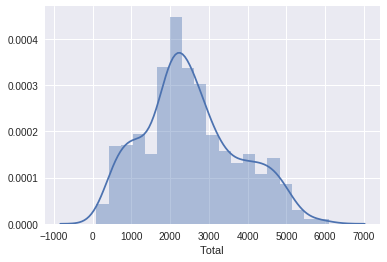

In [0]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

In [0]:
y_train.describe()

count     963.000000
mean     2534.329180
std      1224.065027
min        98.000000
25%      1755.000000
50%      2381.000000
75%      3317.500000
max      6088.000000
Name: Total, dtype: float64

### Basic baseline 1

In [0]:
import numpy as np
y_pred = np.full(shape=y_train.shape, fill_value=y_train.mean())
mean_absolute_error(y_train, y_pred)

980.8981106765484

### Basic baseline 2

In [0]:
mean_absolute_error(y_train, X_train.Total_yesterday)

708.061266874351

### First model that does better than a basic baseline

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

scores = cross_validate(LinearRegression(), X_train, y_train,
                       scoring='neg_mean_absolute_error', cv=3,
                       return_train_score=True, return_estimator=True)

#The negative just “tricks” the model that looks for a max value into looking for a minimum value.

pd.DataFrame(scores).rename(columns={'test_score': 'validation_score'})

,estimator,fit_time,score_time,validation_score,train_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.003217,0.001922,-552.660767,-619.229120
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.002616,0.002161,-655.605924,-582.660550
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.002080,0.001743,-616.111949,-588.415234


In [0]:
scores['test_score'].mean()

-608.1262136279812

In [0]:
import statsmodels.api as sm
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.626
Method:                 Least Squares   F-statistic:                     230.7
Date:                Wed, 30 Jan 2019   Prob (F-statistic):          2.45e-200
Time:                        21:21:37   Log-Likelihood:                -7736.2
No. Observations:                 963   AIC:                         1.549e+04
Df Residuals:                     955   BIC:                         1.553e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             574.1199     93.084     

## 5. Develop a model that overfits. 

"The universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. To figure out where this border lies, first you must cross it." —Chollet

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png">

Diagram source: https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

### Polynomial Regression?

In [0]:
# Copied from cell 10 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [0]:
for degree in [0, 1, 2, 3]:
    features = PolynomialFeatures(degree).fit(X_train).get_feature_names(X_train.columns)
    print(f'{degree} degree polynomial has {len(features)} features')
    print(features)
    print('\n')

0 degree polynomial has 1 features
['1']


1 degree polynomial has 8 features
['1', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday']


2 degree polynomial has 36 features
['1', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'PRCP^2', 'PRCP SNOW', 'PRCP SNWD', 'PRCP TMAX', 'PRCP TMIN', 'PRCP AWND', 'PRCP Total_yesterday', 'SNOW^2', 'SNOW SNWD', 'SNOW TMAX', 'SNOW TMIN', 'SNOW AWND', 'SNOW Total_yesterday', 'SNWD^2', 'SNWD TMAX', 'SNWD TMIN', 'SNWD AWND', 'SNWD Total_yesterday', 'TMAX^2', 'TMAX TMIN', 'TMAX AWND', 'TMAX Total_yesterday', 'TMIN^2', 'TMIN AWND', 'TMIN Total_yesterday', 'AWND^2', 'AWND Total_yesterday', 'Total_yesterday^2']


3 degree polynomial has 120 features
['1', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'PRCP^2', 'PRCP SNOW', 'PRCP SNWD', 'PRCP TMAX', 'PRCP TMIN', 'PRCP AWND', 'PRCP Total_yesterday', 'SNOW^2', 'SNOW SNWD', 'SNOW TMAX', 'SNOW TMIN', 'SNOW AWND', 'SNOW Total_yesterday', 'SNWD^2', 'SNWD TMAX'

### Validation curve (with Polynomial Regression)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html

> Validation curve. Determine training and test scores for varying parameter values. This is similar to grid search with one parameter.

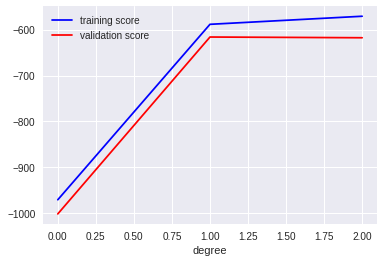

In [0]:
# Modified from cell 13 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

degree = [0, 1, 2]
train_score, val_score = validation_curve(
    PolynomialRegression(), X_train, y_train,
    param_name='polynomialfeatures__degree', param_range=degree, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('degree');

### Grid Search (with Polynomial Regression)

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/grid_search.html

In [0]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'polynomialfeatures__degree': [0,1,2,3]
}

gridsearch = GridSearchCV(PolynomialRegression(), param_grid=param_grid,
                         scoring='neg_mean_absolute_error', cv=3,
                         return_train_score=True, verbose=10)

gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-1026.3529857047195, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-1001.6149251268913, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-927.0707048650538, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-552.6607673839432, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-655.6059243047438, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-616.1119491952567, total=   0.0s
[CV] polynomialfeatures__degree=2 ......................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.1s remaining:    0.0s


[CV]  polynomialfeatures__degree=3, score=-7070.347353517414, total=   0.0s
[CV] polynomialfeatures__degree=3 ....................................
[CV]  polynomialfeatures__degree=3, score=-670.4655783692288, total=   0.0s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomialfeatures__degree': [0, 1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [0]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_polynomialfeatures__degree,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.003408,0.001870,-608.126214,-596.768301,1,{'polynomialfeatures__degree': 1},1,-552.660767,-619.229120,-655.605924,-582.660550,-616.111949,-588.415234,0.000546,0.000141,42.404837,16.055018
2,0.008513,0.005343,-613.613059,-579.248923,2,{'polynomialfeatures__degree': 2},2,-552.752271,-597.626665,-670.404254,-570.822461,-617.682652,-569.297645,0.002606,0.000849,48.117346,13.009927
0,0.004786,0.001867,-985.012872,-979.844161,0,{'polynomialfeatures__degree': 0},3,-1026.352986,-968.880368,-1001.614925,-970.755413,-927.070705,-999.896701,0.002700,0.000312,42.197661,14.199935
3,0.030120,0.009494,-2774.345878,-607.269530,3,{'polynomialfeatures__degree': 3},4,-582.224702,-567.497214,-7070.347354,-680.411953,-670.465578,-573.899425,0.001904,0.002504,3037.945372,51.785503


### Random Forest?

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

In [0]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=20)

scores = cross_validate(model, X_train, y_train,
                       scoring='neg_mean_absolute_error',
                       cv=3, return_train_score=True,
                       return_estimator=True)

pd.DataFrame(scores)

,estimator,fit_time,score_time,test_score,train_score
0,"(DecisionTreeRegressor(criterion='mse', max_de...",0.207941,0.011349,-559.345646,-240.796665
1,"(DecisionTreeRegressor(criterion='mse', max_de...",0.207856,0.012222,-638.776037,-224.951598
2,"(DecisionTreeRegressor(criterion='mse', max_de...",0.207700,0.012127,-646.906745,-222.462039


In [0]:
scores['test_score'].mean()

-615.0094756382996

### Validation Curve (with Random Forest)

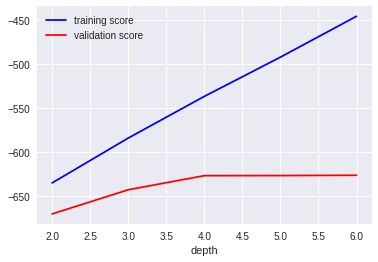

In [0]:
# Modified from cell 13 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html#Validation-curves-in-Scikit-Learn

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

model = RandomForestRegressor(n_estimators=100)

depth = [2, 3, 4, 5, 6]
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

### Grid Search (with Random Forest)

In [0]:
%%time

param_grid = {
    'n_estimators': [100,200],
    'max_depth': [4,5],
    'criterion': ['mse','mae']
}

gridsearch = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
                         scoring='neg_mean_absolute_error', cv=3,
                         return_train_score=True, verbose=10)

gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-554.6786635636621, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-641.1283357454539, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=100, score=-625.078756053627, total=   0.1s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-548.0529299069441, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-641.2121363885035, total=   0.2s
[CV] criterion=mse, max_depth=4, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s


[CV]  criterion=mse, max_depth=4, n_estimators=200, score=-621.8602826131357, total=   0.2s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-548.0461462797547, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.4s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-641.9594754709308, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=100 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=100, score=-625.6939247524766, total=   0.1s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.7s remaining:    0.0s


[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-542.6554643569772, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-637.1431045826347, total=   0.3s
[CV] criterion=mse, max_depth=5, n_estimators=200 ....................
[CV]  criterion=mse, max_depth=5, n_estimators=200, score=-627.2072119734082, total=   0.3s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-543.0679595015577, total=   0.7s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-636.1002647975077, total=   0.6s
[CV] criterion=mae, max_depth=4, n_estimators=100 ....................
[CV]  criterion=mae, max_depth=4, n_estimators=100, score=-612.3796573208723, total=   0.7s
[CV] criterion=mae, max_depth=4, n_estimators=200 ....................
[CV]  criterion=mae, m

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   15.1s finished


CPU times: user 16.4 s, sys: 14.8 ms, total: 16.4 s
Wall time: 16.4 s


In [0]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from gridsearch of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

Best result from gridsearch of 8 parameter combinations


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
6,0.73544,0.007488,-595.356625,-492.622079,mae,5,100,"{'criterion': 'mae', 'max_depth': 5, 'n_estima...",1,-538.959206,-513.671815,-635.35472,-478.9894,-611.75595,-485.205023,0.004028,0.000042,41.026229,15.099161


## FEATURE ENGINEERING!

Jake VanderPlas demonstrates this feature engineering: 
https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

In [0]:
# Modified from code cells 17-21 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic


# patterns of use generally vary from day to day; 
# let's add binary columns that indicate the day of the week:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, day in enumerate(days):
    X_train[day] = (X_train.index.dayofweek == i).astype(float)


    
# we might expect riders to behave differently on holidays; 
# let's add an indicator of this as well:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
X_train = X_train.join(pd.Series(1, index=holidays, name='holiday'))
X_train['holiday'].fillna(0, inplace=True)



# We also might suspect that the hours of daylight would affect 
# how many people ride; let's use the standard astronomical calculation 
# to add this information:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

X_train['daylight_hrs'] = list(map(hours_of_daylight, X_train.index))



# temperatures are in 1/10 deg C; convert to C
X_train['TMIN'] /= 10
X_train['TMAX'] /= 10

# We can also calculate the average temperature.
X_train['Temp (C)'] = 0.5 * (X_train['TMIN'] + X_train['TMAX'])



# precip is in 1/10 mm; convert to inches
X_train['PRCP'] /= 254

# In addition to the inches of precipitation, let's add a flag that 
# indicates whether a day is dry (has zero precipitation):
X_train['dry day'] = (X_train['PRCP'] == 0).astype(int)



# Let's add a counter that increases from day 1, and measures how many 
# years have passed. This will let us measure any observed annual increase 
# or decrease in daily crossings:
X_train['annual'] = (X_train.index - X_train.index[0]).days / 365.

### Linear Regression (with new features)

In [0]:
scores = cross_validate(LinearRegression(), X_train, y_train,
                       scoring='neg_mean_absolute_error', cv=3,
                       return_train_score=True, return_estimator=True)

pd.DataFrame(scores)

,estimator,fit_time,score_time,test_score,train_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.007711,0.002811,-297.513331,-294.270373
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.006459,0.002278,-303.304222,-283.122196
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.008069,0.005041,-322.471789,-283.465246


### Random Forest (with new features)

In [0]:
%%time

param_grid = {
    'n_estimators': [100],
    'max_depth': [5,10,15],
    'criterion': ['mae']
}

gridsearch = GridSearchCV(RandomForestRegressor(), param_grid=param_grid,
                         scoring='neg_mean_absolute_error', cv=3,
                         return_train_score=True, verbose=10)

gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] criterion=mae, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=5, n_estimators=100, score=-353.5919626168225, total=   1.7s
[CV] criterion=mae, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  criterion=mae, max_depth=5, n_estimators=100, score=-379.9800778816199, total=   1.6s
[CV] criterion=mae, max_depth=5, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  criterion=mae, max_depth=5, n_estimators=100, score=-340.24892523364485, total=   1.6s
[CV] criterion=mae, max_depth=10, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.9s remaining:    0.0s


[CV]  criterion=mae, max_depth=10, n_estimators=100, score=-345.6107009345794, total=   2.3s
[CV] criterion=mae, max_depth=10, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV]  criterion=mae, max_depth=10, n_estimators=100, score=-324.851230529595, total=   2.2s
[CV] criterion=mae, max_depth=10, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    9.3s remaining:    0.0s


[CV]  criterion=mae, max_depth=10, n_estimators=100, score=-305.7783489096573, total=   2.2s
[CV] criterion=mae, max_depth=15, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   11.6s remaining:    0.0s


[CV]  criterion=mae, max_depth=15, n_estimators=100, score=-351.7379283489097, total=   2.5s
[CV] criterion=mae, max_depth=15, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   14.0s remaining:    0.0s


[CV]  criterion=mae, max_depth=15, n_estimators=100, score=-319.05732087227415, total=   2.3s
[CV] criterion=mae, max_depth=15, n_estimators=100 ...................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   16.4s remaining:    0.0s


[CV]  criterion=mae, max_depth=15, n_estimators=100, score=-297.0978660436137, total=   2.4s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   18.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   18.8s finished


CPU times: user 23.1 s, sys: 20.9 ms, total: 23.1 s
Wall time: 23.1 s


In [0]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from gridsearch of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

Best result from gridsearch of 3 parameter combinations


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,2.398155,0.010584,-322.631038,-109.578037,mae,15,100,"{'criterion': 'mae', 'max_depth': 15, 'n_estim...",1,-351.737928,-112.107383,-319.057321,-105.13817,-297.097866,-111.488559,0.053919,0.000247,22.44939,3.149609


### Ridge Regression (with new features)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [0]:
from sklearn.linear_model import Ridge

param_grid = {
    'alpha':[0.1,1.0,10.]
}

gridsearch = GridSearchCV(Ridge(), param_grid=param_grid,
                      scoring='neg_mean_absolute_error', cv=3,
                       return_train_score=True)

gridsearch.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [0.1, 1.0, 10.0]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

In [0]:
model = gridsearch.best_estimator_

coefficients = model.coef_
intercept = model.intercept_
feature_names= X_train.columns

print('Best Model from grid search cross validation')
print('Intercept', intercept)
print(pd.Series(coefficients, feature_names).to_string())

Best Model from grid search cross validation
Intercept 33.741779570641484
PRCP               -553.070741
SNOW                 -0.002829
SNWD                 -1.877519
TMAX                 63.833062
TMIN                -37.450291
AWND                 -1.900084
Total_yesterday       0.296029
Mon                 779.221395
Tue                 432.700039
Wed                 368.367626
Thu                 274.054021
Fri                  47.251356
Sat               -1099.692199
Sun                -801.902237
holiday            -939.301546
daylight_hrs         70.256463
Temp (C)             13.191386
dry day             298.475434
annual               44.518889


### Compare to statsmodels

In [0]:
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     513.9
Date:                Wed, 30 Jan 2019   Prob (F-statistic):               0.00
Time:                        21:27:01   Log-Likelihood:                -7092.4
No. Observations:                 963   AIC:                         1.422e+04
Df Residuals:                     945   BIC:                         1.431e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              32.4379     66.241     


### Feature engineering, explained by Francois Chollet

> _Feature engineering_ is the process of using your own knowledge about the data and about the machine learning algorithm at hand to make the algorithm work better by applying hardcoded (nonlearned) transformations to the data before it goes into the model. In many cases, it isn’t reasonable to expect a machine-learning model to be able to learn from completely arbitrary data. The data needs to be presented to the model in a way that will make the model’s job easier.

> Let’s look at an intuitive example. Suppose you’re trying to develop a model that can take as input an image of a clock and can output the time of day.

> If you choose to use the raw pixels of the image as input data, then you have a difficult machine-learning problem on your hands. You’ll need a convolutional neural network to solve it, and you’ll have to expend quite a bit of computational resources to train the network.

> But if you already understand the problem at a high level (you understand how humans read time on a clock face), then you can come up with much better input features for a machine-learning algorithm: for instance, write a Python script to follow the black pixels of the clock hands and output the (x, y) coordinates of the tip of each hand. Then a simple machine-learning algorithm can learn to associate these coordinates with the appropriate time of day.

> You can go even further: do a coordinate change, and express the (x, y) coordinates as polar coordinates with regard to the center of the image. Your input will become the angle theta of each clock hand. At this point, your features are making the problem so easy that no machine learning is required; a simple rounding operation and dictionary lookup are enough to recover the approximate time of day.

> That’s the essence of feature engineering: making a problem easier by expressing it in a simpler way. It usually requires understanding the problem in depth.

> Before convolutional neural networks became successful on the MNIST digit-classification problem, solutions were typically based on hardcoded features such as the number of loops in a digit image, the height of each digit in an image, a histogram of pixel values, and so on.

> Neural networks are capable of automatically extracting useful features from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for two reasons:

> - Good features still allow you to solve problems more elegantly while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.
> - Good features let you solve a problem with far less data. The ability of deep-learning models to learn features on their own relies on having lots of training data available; if you have only a few samples, then the information value in their features becomes critical.


# ASSIGNMENT

### Core assignment

Complete the notebook cells that were originally commented **`TODO`**. 

Then, focus on feature engineering to improve your cross validation scores. Collaborate with your cohort on Slack. You could start with the ideas [Jake VanderPlas suggests:](https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic)

> Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

At the end of the day, take the last step in the "universal workflow of machine learning" — "You can train your final production model on all the available data (training and validation) and evaluate it one last time on the test set."

See the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) documentation for the `refit` parameter, `best_estimator_` attribute, and `predict` method:

> **refit : boolean, or string, default=True**

> Refit an estimator using the best found parameters on the whole dataset.

> The refitted estimator is made available at the `best_estimator_` attribute and permits using `predict` directly on this `GridSearchCV` instance.

### More options

**A.** Apply this lesson to other datasets.

**B.** We predicted the number of bicycle trips based on that day's weather. But imagine you were asked to predict trips at the beginning of each day, based only on data known at the time of prediction or before — so you cannot use the current day's weather. How would you wrangle the features to handle this new requirement? How does this impact the predictive accuracy and coefficients of your models?

**C.** In additon to `GridSearchCV`, scikit-learn has [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html), which is sometimes even better. Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.

**D.** _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?




In [0]:
#Starting over clean and doing feature engineering first.



# Modified from cells 15, 16, and 20, at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic

import pandas as pd

counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True, 
                     infer_datetime_format=True)

weather = pd.read_csv('BicycleWeather.csv', index_col='DATE', parse_dates=True, 
                      infer_datetime_format=True)

daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']] # remove other columns

weather_columns = ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND']
daily = daily.join(weather[weather_columns], how='inner')

# Make a feature for yesterday's total
daily['Total_yesterday'] = daily.Total.shift(1)

daily = daily.drop(index=daily.index[0])

daily['SNOW'].replace(-9999,0, inplace=True)
daily['AWND'].replace(-9999,0, inplace=True)


# Modified from code cells 17-21 at
# https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html#Example:-Predicting-Bicycle-Traffic


# patterns of use generally vary from day to day; 
# let's add binary columns that indicate the day of the week:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i, day in enumerate(days):
    daily[day] = (daily.index.dayofweek == i).astype(float)


    
# we might expect riders to behave differently on holidays; 
# let's add an indicator of this as well:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)



# We also might suspect that the hours of daylight would affect 
# how many people ride; let's use the standard astronomical calculation 
# to add this information:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))



# temperatures are in 1/10 deg C; convert to C
daily['TMIN'] /= 10
daily['TMAX'] /= 10

# We can also calculate the average temperature.
daily['Temp (C)'] = 0.5 * (daily['TMIN'] + daily['TMAX'])



# precip is in 1/10 mm; convert to inches
daily['PRCP'] /= 254

# In addition to the inches of precipitation, let's add a flag that 
# indicates whether a day is dry (has zero precipitation):
daily['dry day'] = (daily['PRCP'] == 0).astype(int)



# Let's add a counter that increases from day 1, and measures how many 
# years have passed. This will let us measure any observed annual increase 
# or decrease in daily crossings:
daily['annual'] = (daily.index - daily.index[0]).days / 365.

#Adding in weekday vs weekend
daily['weekday'] = ((daily['Sat'] == 0) & (daily['Sun'] == 0)).astype(int)

daily.head()

,Total,PRCP,SNOW,SNWD,TMAX,TMIN,AWND,Total_yesterday,Mon,Tue,...,Thu,Fri,Sat,Sun,holiday,daylight_hrs,Temp (C),dry day,annual,weekday
2012-10-04,3475.0,0.0,0,0,18.9,8.3,65,3521.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,11.219142,13.60,1,0.000000,1
2012-10-05,3148.0,0.0,0,0,21.7,8.9,57,3475.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,11.161038,15.30,1,0.002740,1
2012-10-06,2006.0,0.0,0,0,23.9,7.8,51,3148.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,11.103056,15.85,1,0.005479,0
2012-10-07,2142.0,0.0,0,0,23.9,7.8,13,2006.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,11.045208,15.85,1,0.008219,0
2012-10-08,3537.0,0.0,0,0,21.1,7.8,19,2142.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,10.987503,14.45,1,0.010959,1


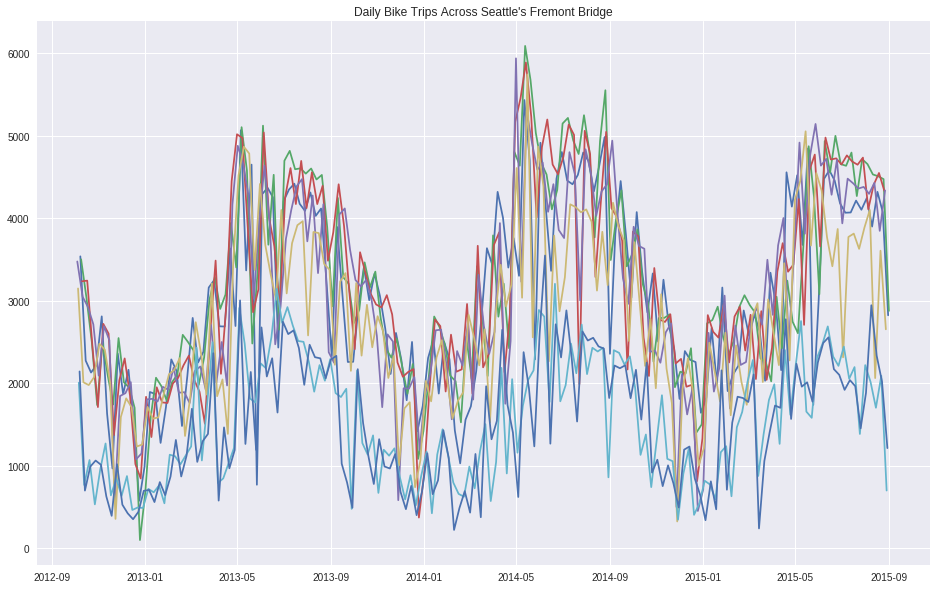

In [0]:
#Look at data overall with some extra features

mon = daily.loc[daily['Mon'] == 1]
tues = daily.loc[daily['Tue'] == 1]
wed = daily.loc[daily['Wed'] == 1]
thur = daily.loc[daily['Thu'] == 1]
fri = daily.loc[daily['Fri'] == 1]
sat = daily.loc[daily['Sat'] == 1]
sun = daily.loc[daily['Sun'] == 1]

plt.figure(figsize=(16,10))

plt.plot(mon.index, mon['Total'])
plt.plot(tues.index, tues['Total'])
plt.plot(wed.index, wed['Total'])
plt.plot(thur.index, thur['Total'])
plt.plot(fri.index, fri['Total'])
plt.plot(sat.index, sat['Total'])
plt.plot(sun.index, sun['Total'])

plt.title("Daily Bike Trips Across Seattle's Fremont Bridge");



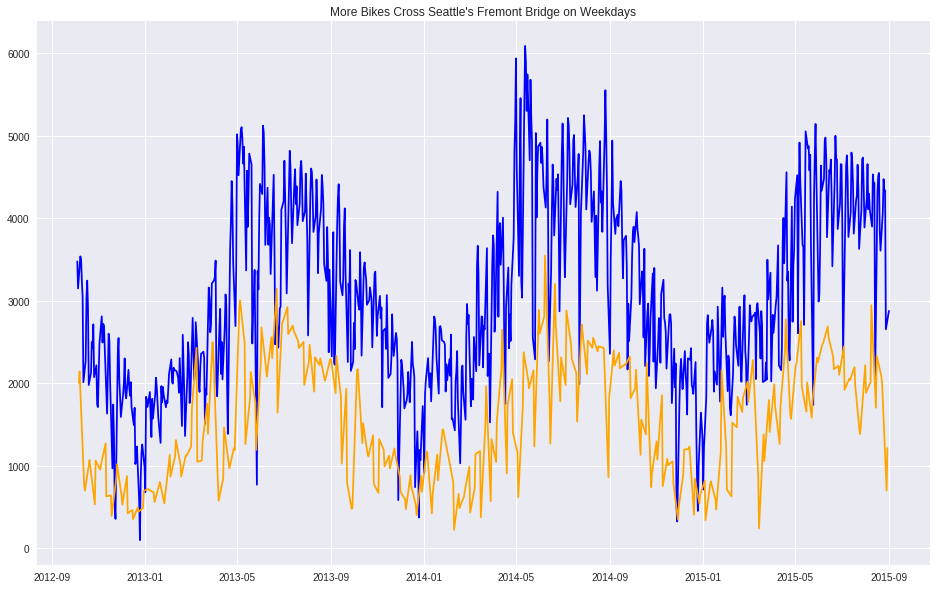

In [0]:
weekday = daily.loc[(daily['Sat'] == 0) & (daily['Sun'] == 0)]
weekend = daily.loc[(daily['Sat'] == 1) | (daily['Sun'] == 1)]

plt.figure(figsize=(16,10))

plt.plot(weekday.index, weekday['Total'], color='blue')
plt.plot(weekend.index, weekend['Total'], color='orange')


plt.title("More Bikes Cross Seattle's Fremont Bridge on Weekdays");


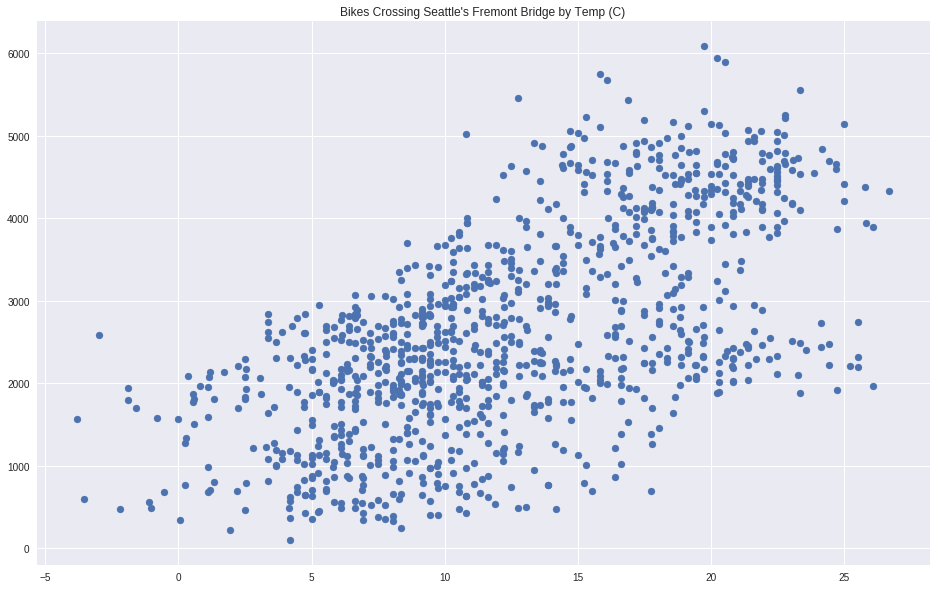

In [0]:
plt.figure(figsize=(16,10))
plt.scatter(daily['Temp (C)'], daily['Total'])

plt.title("Bikes Crossing Seattle's Fremont Bridge by Temp (C)");

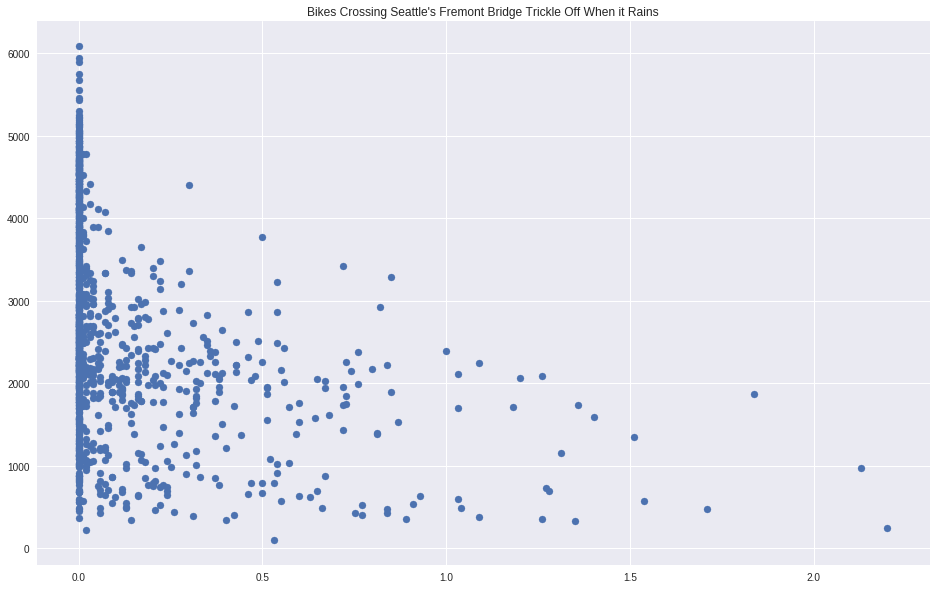

In [0]:
plt.figure(figsize=(16,10))
plt.scatter(daily['PRCP'], daily['Total'])

plt.title("Bikes Crossing Seattle's Fremont Bridge Trickle Off When it Rains");

In [0]:
train = daily[:-100]
test = daily[-100:]

X_train = train.drop(columns='Total')
y_train = train.Total

X_test  = test.drop(columns='Total')
y_test  = test.Total

In [0]:
import numpy as np
y_pred = np.full(shape=y_train.shape, fill_value=y_train.mean())
mean_absolute_error(y_train, y_pred)

980.8981106765484

In [0]:
mean_absolute_error(y_train, X_train.Total_yesterday)

708.061266874351

In [0]:
#Linear Regression

scores = cross_validate(LinearRegression(), X_train, y_train, 
                        scoring='neg_mean_absolute_error', cv=3, 
                        return_train_score=True, return_estimator=True)

pd.DataFrame(scores)

#This is significantly better than doing the model before feature engineering

,estimator,fit_time,score_time,test_score,train_score
0,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.005089,0.002258,-297.513331,-294.270373
1,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.007520,0.002010,-303.304222,-283.122196
2,"LinearRegression(copy_X=True, fit_intercept=Tr...",0.007776,0.002131,-322.471789,-283.465246


In [0]:
scores['test_score'].mean()  #was 607.43 before FE

-307.76311365717976

In [0]:
model = sm.OLS(y_train, sm.add_constant(X_train))
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     513.9
Date:                Wed, 30 Jan 2019   Prob (F-statistic):               0.00
Time:                        22:38:54   Log-Likelihood:                -7092.4
No. Observations:                 963   AIC:                         1.422e+04
Df Residuals:                     945   BIC:                         1.431e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -390.2513     57.483     

In [0]:
#Validation Curve with polynomial regression

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

In [0]:
for degree in [0, 1, 2, 3]:
    features = PolynomialFeatures(degree).fit(X_train).get_feature_names(X_train.columns)
    print(f'{degree} degree polynomial has {len(features)} features')
    print(features)
    print('\n')

0 degree polynomial has 1 features
['1']


1 degree polynomial has 21 features
['1', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs', 'Temp (C)', 'dry day', 'annual', 'weekday']


2 degree polynomial has 231 features
['1', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'AWND', 'Total_yesterday', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday', 'daylight_hrs', 'Temp (C)', 'dry day', 'annual', 'weekday', 'PRCP^2', 'PRCP SNOW', 'PRCP SNWD', 'PRCP TMAX', 'PRCP TMIN', 'PRCP AWND', 'PRCP Total_yesterday', 'PRCP Mon', 'PRCP Tue', 'PRCP Wed', 'PRCP Thu', 'PRCP Fri', 'PRCP Sat', 'PRCP Sun', 'PRCP holiday', 'PRCP daylight_hrs', 'PRCP Temp (C)', 'PRCP dry day', 'PRCP annual', 'PRCP weekday', 'SNOW^2', 'SNOW SNWD', 'SNOW TMAX', 'SNOW TMIN', 'SNOW AWND', 'SNOW Total_yesterday', 'SNOW Mon', 'SNOW Tue', 'SNOW Wed', 'SNOW Thu', 'SNOW Fri', 'SNOW Sat', 'SNOW Sun', 'SNOW holiday', 'SNOW daylight_hrs', 'SNOW

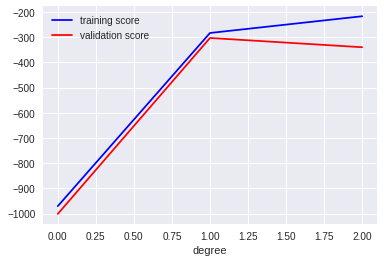

In [0]:
degree = [0, 1, 2]
train_score, val_score = validation_curve(
    PolynomialRegression(), X_train, y_train,
    param_name='polynomialfeatures__degree', param_range=degree, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')

plt.xlabel('degree');

In [0]:
#Gridsearch with polynomial regression

param_grid = {
    'polynomialfeatures__degree': [0, 1, 2, 3]
}

gridsearch = GridSearchCV(PolynomialRegression(), param_grid=param_grid, 
                          scoring='neg_mean_absolute_error', cv=3, 
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-1026.3529857047195, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-1001.6149251268913, total=   0.0s
[CV] polynomialfeatures__degree=0 ....................................
[CV]  polynomialfeatures__degree=0, score=-927.0707048650538, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-297.5133305630361, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-303.3042218933308, total=   0.0s
[CV] polynomialfeatures__degree=1 ....................................
[CV]  polynomialfeatures__degree=1, score=-322.47178851518737, total=   0.0s
[CV] polynomialfeatures__degree=2 .....................

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s


[CV]  polynomialfeatures__degree=2, score=-340.04902720971273, total=   0.1s
[CV] polynomialfeatures__degree=3 ....................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s


[CV]  polynomialfeatures__degree=3, score=-7837.805501332768, total=   0.5s
[CV] polynomialfeatures__degree=3 ....................................
[CV]  polynomialfeatures__degree=3, score=-244393.39623296048, total=   0.4s
[CV] polynomialfeatures__degree=3 ....................................
[CV]  polynomialfeatures__degree=3, score=-3477.2453199312863, total=   0.4s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.7s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'polynomialfeatures__degree': [0, 1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=10)

In [0]:
pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_polynomialfeatures__degree,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
1,0.005151,0.002430,-307.763114,-286.952605,1,{'polynomialfeatures__degree': 1},1,-297.513331,-294.270373,-303.304222,-283.122196,-322.471789,-283.465246,0.000229,0.000089,10.665910,5.176338
2,0.034636,0.010293,-342.564036,-228.393653,2,{'polynomialfeatures__degree': 2},2,-393.252501,-263.537170,-294.390581,-204.581285,-340.049027,-217.062503,0.000807,0.004975,40.399371,25.367240
0,0.005729,0.001852,-985.012872,-979.844161,0,{'polynomialfeatures__degree': 0},3,-1026.352986,-968.880368,-1001.614925,-970.755413,-927.070705,-999.896701,0.003738,0.000113,42.197661,14.199935
3,0.390841,0.039428,-85236.149018,-117.551015,3,{'polynomialfeatures__degree': 3},4,-7837.805501,-118.248211,-244393.396233,-111.188717,-3477.245320,-123.216118,0.028724,0.010277,112555.247551,4.934852


In [0]:
#Random Forest

model = RandomForestRegressor(n_estimators=100, max_depth=20)

scores = cross_validate(model, X_train, y_train, 
                        scoring='neg_mean_absolute_error', 
                        cv=3, return_train_score=True, 
                        return_estimator=True)

pd.DataFrame(scores)

#Down to 284!!

,estimator,fit_time,score_time,test_score,train_score
0,"(DecisionTreeRegressor(criterion='mse', max_de...",0.340038,0.010544,-346.878551,-104.420531
1,"(DecisionTreeRegressor(criterion='mse', max_de...",0.324049,0.011204,-321.195088,-95.501444
2,"(DecisionTreeRegressor(criterion='mse', max_de...",0.328813,0.010956,-284.783763,-103.509424


In [0]:
scores['test_score'].mean()

-317.6191343025268

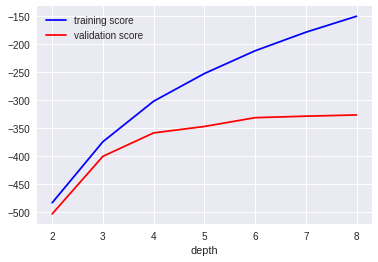

In [0]:
#Validation Curve with Random Forest

model = RandomForestRegressor(n_estimators=100)

depth = [2, 3, 4, 5, 6, 7, 8]
train_score, val_score = validation_curve(
    model, X_train, y_train,
    param_name='max_depth', param_range=depth, 
    scoring='neg_mean_absolute_error', cv=3)

plt.plot(depth, np.median(train_score, 1), color='blue', label='training score')
plt.plot(depth, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('depth');

In [0]:
#Grid Search with Random Forest

%%time

param_grid = {
    'n_estimators': [100, 200], 
    'max_depth': [6, 7], 
    'criterion': ['mae']
}

gridsearch = GridSearchCV(RandomForestRegressor(), param_grid=param_grid, 
                          scoring='neg_mean_absolute_error', cv=3, 
                          return_train_score=True, verbose=10)

gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] criterion=mae, max_depth=6, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mae, max_depth=6, n_estimators=100, score=-352.2408566978193, total=   1.7s
[CV] criterion=mae, max_depth=6, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  criterion=mae, max_depth=6, n_estimators=100, score=-346.7602647975078, total=   1.7s
[CV] criterion=mae, max_depth=6, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.4s remaining:    0.0s


[CV]  criterion=mae, max_depth=6, n_estimators=100, score=-294.6822585669782, total=   1.7s
[CV] criterion=mae, max_depth=6, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.1s remaining:    0.0s


[CV]  criterion=mae, max_depth=6, n_estimators=200, score=-347.94255451713394, total=   3.4s
[CV] criterion=mae, max_depth=6, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    8.6s remaining:    0.0s


[CV]  criterion=mae, max_depth=6, n_estimators=200, score=-345.6715809968847, total=   3.4s
[CV] criterion=mae, max_depth=6, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.0s remaining:    0.0s


[CV]  criterion=mae, max_depth=6, n_estimators=200, score=-295.58620716510904, total=   3.5s
[CV] criterion=mae, max_depth=7, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   15.5s remaining:    0.0s


[CV]  criterion=mae, max_depth=7, n_estimators=100, score=-360.23566978193145, total=   1.9s
[CV] criterion=mae, max_depth=7, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   17.4s remaining:    0.0s


[CV]  criterion=mae, max_depth=7, n_estimators=100, score=-333.6477414330218, total=   1.8s
[CV] criterion=mae, max_depth=7, n_estimators=100 ....................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   19.2s remaining:    0.0s


[CV]  criterion=mae, max_depth=7, n_estimators=100, score=-285.4181308411215, total=   1.9s
[CV] criterion=mae, max_depth=7, n_estimators=200 ....................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   21.1s remaining:    0.0s


[CV]  criterion=mae, max_depth=7, n_estimators=200, score=-351.3322118380063, total=   3.7s
[CV] criterion=mae, max_depth=7, n_estimators=200 ....................
[CV]  criterion=mae, max_depth=7, n_estimators=200, score=-336.2352492211838, total=   3.6s
[CV] criterion=mae, max_depth=7, n_estimators=200 ....................
[CV]  criterion=mae, max_depth=7, n_estimators=200, score=-285.81084112149534, total=   3.7s


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   32.2s finished


CPU times: user 38.7 s, sys: 8.99 ms, total: 38.7 s
Wall time: 38.7 s


In [0]:
results = pd.DataFrame(gridsearch.cv_results_)
print(f'Best result from grid search of {len(results)} parameter combinations')
results.sort_values(by='rank_test_score').head(1)

Best result from grid search of 4 parameter combinations


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_criterion,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
3,3.670148,0.014791,-324.459434,-183.192862,mae,7,200,"{'criterion': 'mae', 'max_depth': 7, 'n_estima...",1,-351.332212,-189.414945,-336.235249,-170.715993,-285.810841,-189.447648,0.03557,0.000274,28.015054,8.822489
